#  **Практическое занятие №5. Домашняя работа (задачи 1-4)**

## **Stage 0** - Импорт и настройки
### Основные библиотеки

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision.transforms import v2

############################################# У вас может не быть этой библиотеки!
from torchsummary import summary
from torchinfo import summary as info_summary
#############################################

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



dataset_seed = 777
batch_size = None

labels_map = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",}

# Base Augmentation
base_augmentation = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.5], std=[255/2])
])

torch.backends.cudnn.benchmark = True  # Boost speed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


### Utils - Полезные функции

In [194]:
def get_softmax(current_model, input_tensor, augmentation=base_augmentation, round_res=None):
    input_tensor = input_tensor.to(device)
    logits = current_model(augmentation(input_tensor))
    sm = F.softmax(logits, dim=-1).detach().cpu().numpy()
    if round_res:
        return np.round(sm, round_res)
    return sm

def np_softmax(logits):
    assert len(logits.shape) == 2
    s = np.max(logits, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(logits - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div


def save_model(model_: nn.Module, name=""):
    name = name if name else model_.name
    torch.save(model_.state_dict(), f"models/{name}.pth")

def load_model(model_class, name="") -> nn.Module:
    name = name if name else model_class.base_name
    model_ = model_class()
    model_.load_state_dict(torch.load(f"models/{name}.pth"))
    model_.to(device)
    model_.eval()
    return model_


def show_history(history_):
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_["train_losses"], label='Training loss')
    plt.plot(history_["val_losses"], label='Validation loss')
    plt.legend(frameon=False)
    plt.title("Loss on training")
    
    plt.subplot(1, 2, 2)
    plt.plot(history_["train_accuracy"], label='Training accuracy')
    plt.plot(history_["val_accuracy"], label='Validation accuracy')
    plt.legend(frameon=False)
    plt.title("Accuracy on training")
    plt.show()

def test_model(model_: nn.Module, loader: torch.utils.data.DataLoader, augmentation=base_augmentation, history_to_show=None):
    if history_to_show:
        show_history(history_to_show)

    with torch.no_grad():
        y_pred = y_true = None
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            images = augmentation(images)
            if y_pred is not None:
                y_pred = np.vstack([y_pred, model_(images).detach().cpu().numpy()])
                y_true = np.vstack([y_true, labels.detach().cpu().numpy()])
            else:
                y_pred = model_(images).detach().cpu().numpy()
                y_true = labels.detach().cpu().numpy()
    
    y_pred = np_softmax(y_pred)
    y_pred_onehot = F.one_hot(torch.argmax(torch.Tensor(y_pred), dim=-1))
    # print(np.round(y_pred[:15], 3))
    print(sklearn.metrics.classification_report(y_true, y_pred_onehot, target_names=list(labels_map.values())))
    print(f"Accuracy test:  {sklearn.metrics.accuracy_score(y_true, y_pred_onehot) :.4f}")

## **Stage 1** - Задача 1 - Датасет и полносвязная сеть

### Dataset

In [250]:
# Загрузка
dataset_train_val_ = datasets.FashionMNIST(root='datasets/FashionMNIST', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataset_test_      = datasets.FashionMNIST(root='datasets/FashionMNIST', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(dataset_train_val_, dataset_test_, sep='\n')


# Подготовка dataset_train_val
x, y = dataset_train_val_.data, dataset_train_val_.targets

y = F.one_hot(y, num_classes=10).to(torch.float)
x = x[:, None, :, :]  # / 255  * 2 - 1

print(x.shape, y.shape)
print(torch.max(x), torch.min(x), x.dtype)  # torch.mean(x)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=(1 / 6), random_state=dataset_seed)

train_dataset = TensorDataset(x_train, y_train)
val_dataset   = TensorDataset(x_val,   y_val)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader    = torch.utils.data.DataLoader(val_dataset,   batch_size=256, shuffle=False)


# Подготовка dataset_test
x_test, y_test = dataset_test_.data, dataset_test_.targets

y_test = F.one_hot(y_test, num_classes=10).to(torch.float)
x_test = x_test[:, None, :, :]  # / 255 * 2 - 1
print(x_test.shape, y_test.shape)

test_dataset = TensorDataset(x_test, y_test)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets/FashionMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: datasets/FashionMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 1, 28, 28]) torch.Size([60000, 10])
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8) torch.uint8
torch.Size([10000, 1, 28, 28]) torch.Size([10000, 10])


#### See dataset

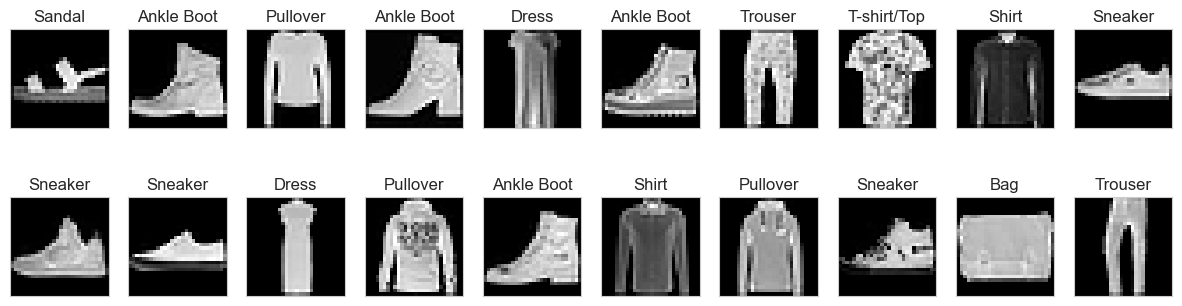

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


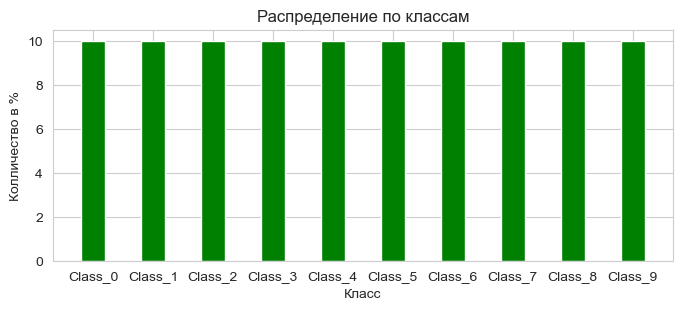

In [10]:
def show_from_loader(dataset: TensorDataset, augmentation=base_augmentation, rows=2, cols=10, start_idx=0):
    imgs_, labels_ = dataset[start_idx:start_idx+rows * cols]
    
    plt.figure(figsize=(int(1.55*cols), 2*rows))
    for i in range(cols*rows):
        # i_img_ = np.clip((imgs_[i].numpy() + 1) / 2, 0., 1.)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.expand_dims(np.squeeze(augmentation(imgs_[i])), axis=-1), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(labels_map[np.argmax(labels_[i].numpy())])
    
    plt.show()
    

show_from_loader(train_dataset)
# show_from_loader(train_dataset, 3, 9)
# show_from_loader(train_dataset, 1, 4)

# Распределение
stat = y.numpy()
stat = np.mean(stat, axis=0)
print(stat)

fig = plt.figure(figsize=(8, 3))
plt.bar([f"Class_{i}" for i in range(10)], stat * 100, color='green', width=0.4)
plt.xlabel("Класс")
plt.ylabel("Колличество в %")
plt.title("Распределение по классам")
plt.show()

### Train cycle

In [134]:
def train(model_training: nn.Module, optim: torch.optim.Optimizer, loss_fn, epochs=1000, augmentation=base_augmentation, callbacks=None, metrics=True):
    train_losses, val_losses = [], []
    train_accuracy, val_accuracy = [], []
    
    # Model Training
    model_training.train()
    for epoch in range(epochs):
        running_loss = train_total_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = augmentation(images)
            # Prevent accumulation of gradients
            optim.zero_grad()
            # Make predictions
            outputs = model_training(images)
            loss = loss_fn(outputs, labels)
            # Backprop
            loss.backward()
            optim.step()
    
            running_loss += loss.item()
            
            # Metrics - Accuracy
            predicted_ = torch.max(outputs.data, 1)[1]
            correct_ = (predicted_ == torch.max(labels, 1)[1]).sum()
            train_total_correct += correct_.detach().cpu().numpy()
            
    
        # Model Validation
        if metrics or callbacks:
            with torch.no_grad():
                model_training.train(False)
                val_loss = val_total_correct = 0
                
                for val_images, val_labels in val_loader:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)
                    val_images = augmentation(val_images)
                    # Forward propagation
                    outputs = model_training(val_images)
                    val_loss += loss_fn(outputs, val_labels)

                    # Metrics - Accuracy
                    predicted_ = torch.max(outputs.data, 1)[1]
                    correct_ = (predicted_ == torch.max(val_labels, 1)[1]).sum()
                    val_total_correct += correct_.detach().cpu().numpy()
    
            model_training.train()
            
            train_losses.append(running_loss / len(train_loader))
            val_losses.append((val_loss.detach().cpu().numpy() / len(val_loader)))

            val_accuracy.append(val_total_correct / len(val_loader.dataset))
            train_accuracy.append(train_total_correct / len(train_loader.dataset))
            
            print(f"Epoch: {epoch + 1}/{epochs} \t",
                  f"Train Loss: {train_losses[-1]:.3f}\t",
                  f"Val Loss: {val_losses[-1]:.3f}\t",
                  f"Train Accuracy: {train_accuracy[-1]:.3f}\t",
                  f"Val Accuracy: {val_accuracy[-1]:.3f}\t",
                  (f"Lr (e-3): {callbacks['lr_scheduler'].optimizer.param_groups[0]['lr'] * 1e3:.2f}"
                   if callbacks and callbacks.get("lr_scheduler") else ""))
            
            if callbacks:
                if "early_stopping" in callbacks.keys():
                    callbacks["early_stopping"].step(val_losses[-1])
                    if callbacks["early_stopping"]:
                        print("INFO: Early stopping!")
                        break
                if "lr_scheduler" in callbacks.keys():
                    callbacks["lr_scheduler"].step(val_losses[-1])


    model_training.train(False)
    return {"train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracy": val_accuracy,
            "train_accuracy": train_accuracy,}

### Full-connected NN

In [6]:
class Model_FNN_Large(nn.Module):
    base_name = "Model_1_FNN_Large"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        self.fc1 = nn.Linear(28 * 28, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(96)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.drop1 = nn.Dropout(p=0.17)
        self.drop2 = nn.Dropout(p=0.20)
        self.drop3 = nn.Dropout(p=0.15)

    def forward(self, x1):
        x2 = torch.flatten(x1, start_dim=1)
        x3 = self.drop1(F.relu(self.bn1(self.fc1(x2))))
        x4 = self.drop2(F.relu(self.bn2(self.fc2(x3))))
        x5 = self.drop3(F.relu(self.bn3(self.fc3(x4))))
        logits = self.fc4(x5)
        return logits

    
class Model_FNN_Small(nn.Module):
    base_name = "Model_1_FNN_Small"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x1):
        x2 = torch.flatten(x1, start_dim=1)
        x3 = self.dropout(F.relu(self.bn1(self.fc1(x2))))
        logits = self.fc2(x3)
        return logits

### Training model

In [53]:
# Instantiate our model
model_fnn = Model_FNN_Large()
model_fnn = model_fnn.to(device)

# Summary (1 or 2)
# summary(model_fnn, input_size=(1, 28, 28), batch_size=128)
print(str(info_summary(model_fnn, input_size=(128, 1, 28, 28))))

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 1e-3
optimizer_fnn_1 = torch.optim.SGD(model_fnn.parameters(), lr=learning_rate)
optimizer_fnn_2 = torch.optim.SGD(model_fnn.parameters(), lr=learning_rate, momentum=0.65, nesterov=True)
optimizer_fnn_3 = torch.optim.RMSprop(model_fnn.parameters(), lr=learning_rate)
optimizer_fnn_4 = torch.optim.Adam(model_fnn.parameters(), lr=learning_rate)

Layer (type:depth-idx)                   Output Shape              Param #
Model_FNN_Large                          [128, 10]                 --
├─Linear: 1-1                            [128, 96]                 75,360
├─BatchNorm1d: 1-2                       [128, 96]                 192
├─Dropout: 1-3                           [128, 96]                 --
├─Linear: 1-4                            [128, 64]                 6,208
├─BatchNorm1d: 1-5                       [128, 64]                 128
├─Dropout: 1-6                           [128, 64]                 --
├─Linear: 1-7                            [128, 64]                 4,160
├─BatchNorm1d: 1-8                       [128, 64]                 128
├─Dropout: 1-9                           [128, 64]                 --
├─Linear: 1-10                           [128, 10]                 650
Total params: 86,826
Trainable params: 86,826
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 11.11
Input size (MB): 0.40
Forward/

In [56]:
# After learning
save_model(model_fnn)

In [57]:
model_fnn = load_model(Model_FNN_Small)
test_model(model_fnn, val_loader)

              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.79      0.83       899
     Trouser       0.99      0.98      0.98      1043
    Pullover       0.86      0.80      0.83      1003
       Dress       0.91      0.93      0.92      1021
        Coat       0.83      0.87      0.85      1020
      Sandal       0.98      0.95      0.97      1008
       Shirt       0.70      0.76      0.73      1014
     Sneaker       0.94      0.94      0.94      1014
         Bag       0.97      0.97      0.97       974
  Ankle Boot       0.93      0.97      0.95      1004

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000
 samples avg       0.90      0.90      0.90     10000

Accuracy test:  0.8966


Epoch: 1/35 	 Train Loss: 0.580	 Val Loss: 0.390	 Train Accuracy: 0.810	 Val Accuracy: 0.863	 
Epoch: 2/35 	 Train Loss: 0.427	 Val Loss: 0.384	 Train Accuracy: 0.848	 Val Accuracy: 0.863	 
Epoch: 3/35 	 Train Loss: 0.393	 Val Loss: 0.354	 Train Accuracy: 0.858	 Val Accuracy: 0.875	 
Epoch: 4/35 	 Train Loss: 0.374	 Val Loss: 0.352	 Train Accuracy: 0.865	 Val Accuracy: 0.873	 
Epoch: 5/35 	 Train Loss: 0.358	 Val Loss: 0.328	 Train Accuracy: 0.871	 Val Accuracy: 0.881	 
Epoch: 6/35 	 Train Loss: 0.346	 Val Loss: 0.326	 Train Accuracy: 0.874	 Val Accuracy: 0.883	 
Epoch: 7/35 	 Train Loss: 0.335	 Val Loss: 0.323	 Train Accuracy: 0.876	 Val Accuracy: 0.884	 
Epoch: 8/35 	 Train Loss: 0.326	 Val Loss: 0.326	 Train Accuracy: 0.881	 Val Accuracy: 0.881	 
Epoch: 9/35 	 Train Loss: 0.320	 Val Loss: 0.318	 Train Accuracy: 0.883	 Val Accuracy: 0.883	 
Epoch: 10/35 	 Train Loss: 0.312	 Val Loss: 0.313	 Train Accuracy: 0.886	 Val Accuracy: 0.885	 
Epoch: 11/35 	 Train Loss: 0.306	 Val Loss: 0.302

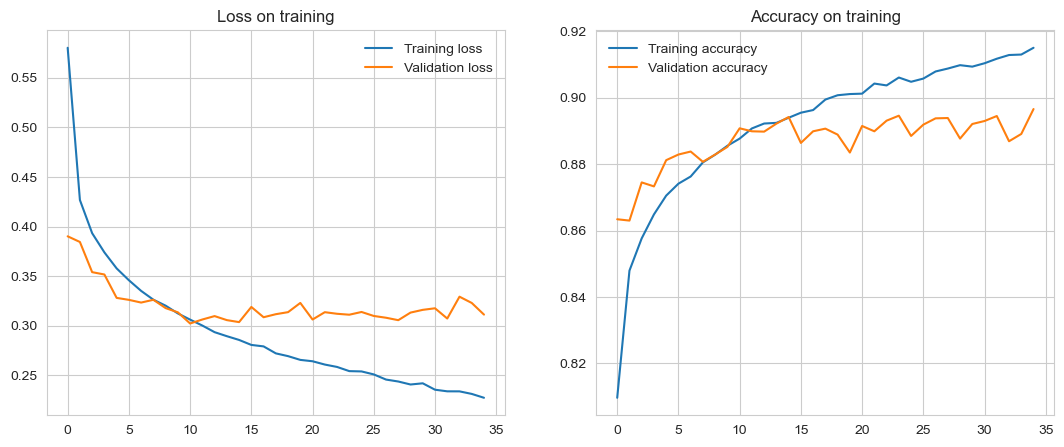

              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.79      0.83       899
     Trouser       0.99      0.98      0.98      1043
    Pullover       0.86      0.80      0.83      1003
       Dress       0.91      0.93      0.92      1021
        Coat       0.83      0.87      0.85      1020
      Sandal       0.98      0.95      0.97      1008
       Shirt       0.70      0.76      0.73      1014
     Sneaker       0.94      0.94      0.94      1014
         Bag       0.97      0.97      0.97       974
  Ankle Boot       0.93      0.97      0.95      1004

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000
 samples avg       0.90      0.90      0.90     10000

Accuracy test:  0.8966


In [51]:
history = train(model_fnn, optimizer_fnn_4, epochs=35, loss_fn=loss_function, augmentation=base_augmentation)
test_model(model_fnn, val_loader, history_to_show=history)

Epoch: 1/35 	 Train Loss: 0.631	 Val Loss: 0.386	 Train Accuracy: 0.795	 Val Accuracy: 0.863	 
Epoch: 2/35 	 Train Loss: 0.448	 Val Loss: 0.362	 Train Accuracy: 0.843	 Val Accuracy: 0.869	 
Epoch: 3/35 	 Train Loss: 0.410	 Val Loss: 0.351	 Train Accuracy: 0.855	 Val Accuracy: 0.872	 
Epoch: 4/35 	 Train Loss: 0.386	 Val Loss: 0.331	 Train Accuracy: 0.861	 Val Accuracy: 0.879	 
Epoch: 5/35 	 Train Loss: 0.371	 Val Loss: 0.312	 Train Accuracy: 0.868	 Val Accuracy: 0.890	 
Epoch: 6/35 	 Train Loss: 0.361	 Val Loss: 0.328	 Train Accuracy: 0.870	 Val Accuracy: 0.883	 
Epoch: 7/35 	 Train Loss: 0.349	 Val Loss: 0.302	 Train Accuracy: 0.875	 Val Accuracy: 0.892	 
Epoch: 8/35 	 Train Loss: 0.335	 Val Loss: 0.307	 Train Accuracy: 0.879	 Val Accuracy: 0.890	 
Epoch: 9/35 	 Train Loss: 0.330	 Val Loss: 0.303	 Train Accuracy: 0.881	 Val Accuracy: 0.892	 
Epoch: 10/35 	 Train Loss: 0.320	 Val Loss: 0.287	 Train Accuracy: 0.884	 Val Accuracy: 0.899	 
Epoch: 11/35 	 Train Loss: 0.310	 Val Loss: 0.287

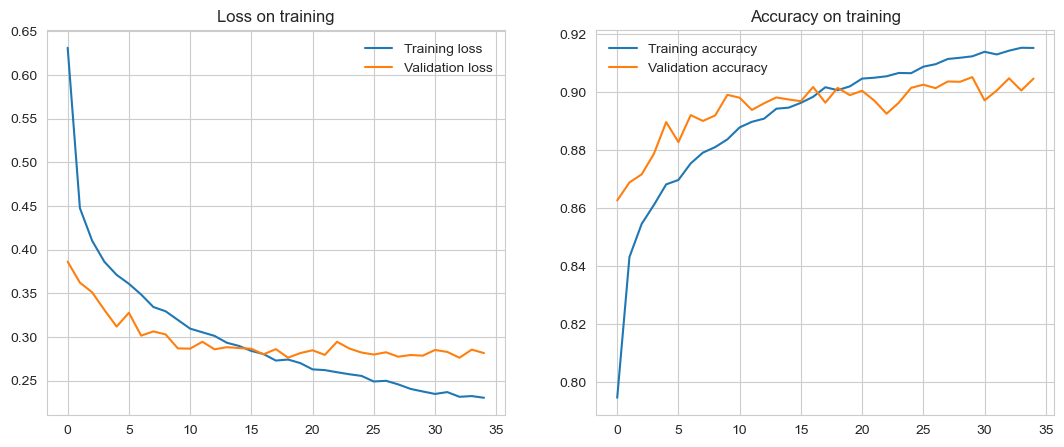

              precision    recall  f1-score   support

 T-shirt/Top       0.82      0.86      0.84       899
     Trouser       0.98      0.98      0.98      1043
    Pullover       0.83      0.84      0.83      1003
       Dress       0.92      0.93      0.92      1021
        Coat       0.86      0.86      0.86      1020
      Sandal       0.98      0.96      0.97      1008
       Shirt       0.76      0.72      0.74      1014
     Sneaker       0.96      0.95      0.95      1014
         Bag       0.98      0.97      0.97       974
  Ankle Boot       0.94      0.97      0.96      1004

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000
 samples avg       0.90      0.90      0.90     10000

Accuracy test:  0.9046


In [55]:
history = train(model_fnn, optimizer_fnn_4, epochs=35, loss_fn=loss_function, augmentation=base_augmentation)
test_model(model_fnn, val_loader, history_to_show=history)

### Выводы (Задача 1)
Я скачал датасет Fashion MNIST, вывел картинки для примера, отделил валидационную, тестовую и обучающую выборку и обучил две полносвязных архитектуры. Выведите summary моделей и графики обучения. Сохранил модели.
Модель Model_FNN_Small смогла 89.3% точности и Model_FNN_Large смогла 90.0% точности. Оптимизатор Adam оказался лучше SGD, шаг обучения 0.001 оптимален

## **Stage 2** - Задача 2 - Свёрточная сеть

### Model CNN

In [7]:
class Model_CNN(nn.Module):
    base_name = "Model_2_CNN"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        
        self.layer1 = nn.Sequential(  # 28x28 -> 13x13
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.08),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(  # 13x13 -> 6x6
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(  # 6x6 -> 3x3
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(  # 3x3 -> 3x3
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=2, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.15),
        )
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc_dropout = nn.Dropout(p=0.17)

    def forward(self, x1):
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        
        f1 = torch.flatten(x5, start_dim=1)
        f2 = self.fc_dropout(F.relu(self.bn1(self.fc1(f1))))
        f3 = self.fc_dropout(F.relu(self.bn2(self.fc2(f2))))
        logits = self.fc3(f3)
        return logits

### Training model

In [8]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.best_loss = 1e9
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if (val_loss - self.best_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:  
                self.early_stop = True

        self.best_loss = min(val_loss, self.best_loss)
    
    def __bool__(self):
        return self.early_stop

In [60]:
# Instantiate our model
model_cnn = Model_CNN()
model_cnn = model_cnn.to(device)

# Summary (1 or 2)
# summary(model_cnn, input_size=(1, 28, 28), batch_size=128)
print(str(info_summary(model_cnn, input_size=(128, 1, 28, 28),
                       col_names=["mult_adds", "output_size", "num_params"], row_settings=["var_names"])))

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 3e-3
optimizer_cnn_1 = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=0.95)
optimizer_cnn_2 = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
cnn_optimizer = optimizer_cnn_1

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, 'min', patience=2, factor=0.65, min_lr=5e-5)
early_stopping = EarlyStopping(tolerance=7, min_delta=0.004)
callbacks_model = {"lr_scheduler": lr_scheduler,
                   "early_stopping": early_stopping}

Layer (type (var_name))                  Mult-Adds                 Output Shape              Param #
Model_CNN (Model_CNN)                    --                        [128, 10]                 --
├─Sequential (layer1)                    --                        [128, 64, 13, 13]         --
│    └─Conv2d (0)                        47,775,744                [128, 32, 27, 27]         512
│    └─BatchNorm2d (1)                   8,192                     [128, 32, 27, 27]         64
│    └─ReLU (2)                          --                        [128, 32, 27, 27]         --
│    └─Dropout2d (3)                     --                        [128, 32, 27, 27]         --
│    └─Conv2d (4)                        1,719,926,784             [128, 64, 27, 27]         18,432
│    └─BatchNorm2d (5)                   16,384                    [128, 64, 27, 27]         128
│    └─ReLU (6)                          --                        [128, 64, 27, 27]         --
│    └─Dropout2d (7)         

Epoch: 1/70 	 Train Loss: 0.724	 Val Loss: 0.362	 Train Accuracy: 0.748	 Val Accuracy: 0.869	 Lr (e-3): 3.00
Epoch: 2/70 	 Train Loss: 0.420	 Val Loss: 0.291	 Train Accuracy: 0.850	 Val Accuracy: 0.892	 Lr (e-3): 3.00
Epoch: 3/70 	 Train Loss: 0.361	 Val Loss: 0.268	 Train Accuracy: 0.873	 Val Accuracy: 0.904	 Lr (e-3): 3.00
Epoch: 4/70 	 Train Loss: 0.328	 Val Loss: 0.253	 Train Accuracy: 0.882	 Val Accuracy: 0.910	 Lr (e-3): 3.00
Epoch: 5/70 	 Train Loss: 0.305	 Val Loss: 0.238	 Train Accuracy: 0.891	 Val Accuracy: 0.918	 Lr (e-3): 3.00
Epoch: 6/70 	 Train Loss: 0.288	 Val Loss: 0.230	 Train Accuracy: 0.898	 Val Accuracy: 0.918	 Lr (e-3): 3.00
Epoch: 7/70 	 Train Loss: 0.274	 Val Loss: 0.228	 Train Accuracy: 0.902	 Val Accuracy: 0.922	 Lr (e-3): 3.00
Epoch: 8/70 	 Train Loss: 0.263	 Val Loss: 0.222	 Train Accuracy: 0.906	 Val Accuracy: 0.925	 Lr (e-3): 3.00
Epoch: 9/70 	 Train Loss: 0.254	 Val Loss: 0.215	 Train Accuracy: 0.910	 Val Accuracy: 0.926	 Lr (e-3): 3.00
Epoch: 10/70 	 Trai

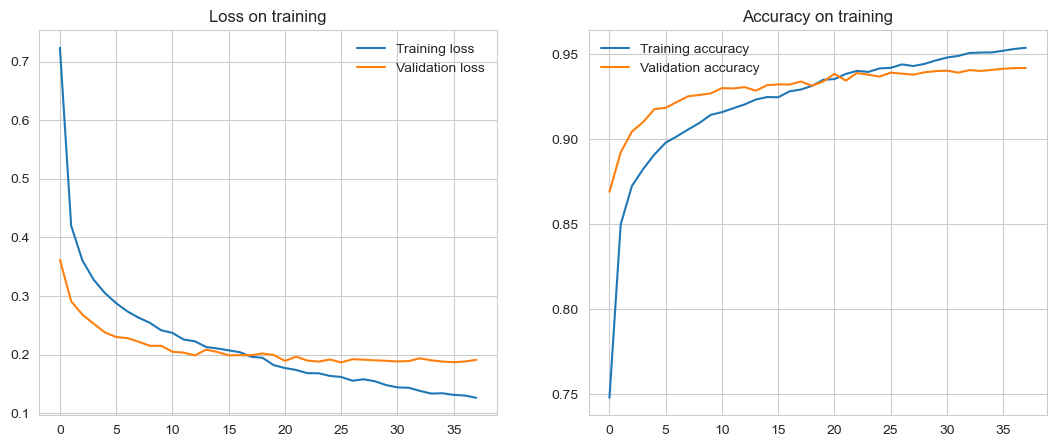

              precision    recall  f1-score   support

 T-shirt/Top       0.87      0.92      0.89       899
     Trouser       0.99      0.99      0.99      1043
    Pullover       0.93      0.90      0.91      1003
       Dress       0.95      0.96      0.95      1021
        Coat       0.88      0.93      0.91      1020
      Sandal       0.99      0.98      0.99      1008
       Shirt       0.86      0.80      0.83      1014
     Sneaker       0.96      0.98      0.97      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.98      0.97      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9418


In [65]:
history = train(model_cnn, cnn_optimizer, epochs=70, loss_fn=loss_function, callbacks=callbacks_model)
test_model(model_cnn, val_loader, history_to_show=history)

In [66]:
save_model(model_cnn)
# load_model(Model_CNN, Model_CNN.base_name)

In [67]:
model_cnn = load_model(Model_CNN, Model_CNN.base_name)
test_model(model_cnn, val_loader)

              precision    recall  f1-score   support

 T-shirt/Top       0.87      0.92      0.89       899
     Trouser       0.99      0.99      0.99      1043
    Pullover       0.93      0.90      0.91      1003
       Dress       0.95      0.96      0.95      1021
        Coat       0.88      0.93      0.91      1020
      Sandal       0.99      0.98      0.99      1008
       Shirt       0.86      0.80      0.83      1014
     Sneaker       0.96      0.98      0.97      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.98      0.97      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9418


### Выводы (Задача 2)
Я добавил в архитектуру свёртки. Реализовал callbacks. Выведел summary модели и графики обучения. Сохранил модель.
Модель Model_CNN смогла 94.2% точности.

## **Stage 3** - Задача 3 - Аугментации

In [86]:
augmentation_v1_simple = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.1, contrast=0.1),
    base_augmentation,
])
augmentation_v2_auto = v2.Compose([
    v2.AugMix(),
    v2.RandomHorizontalFlip(p=0.3),
    base_augmentation,
])
augmentation_v3_auto = v2.Compose([
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    v2.RandomHorizontalFlip(p=0.3),
    base_augmentation,
])
augmentation_v4_auto = v2.Compose([
    v2.RandAugment(3),
    v2.RandomHorizontalFlip(p=0.3),
    base_augmentation,
])
# augmentation_v5 -> MixUp and CutMix

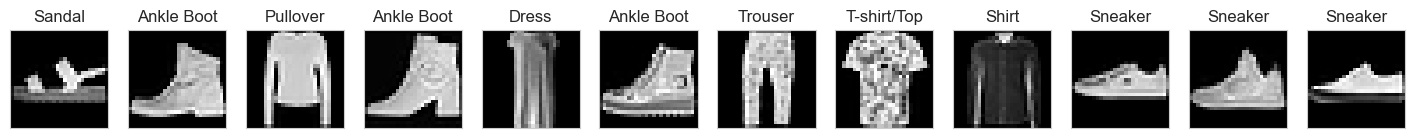

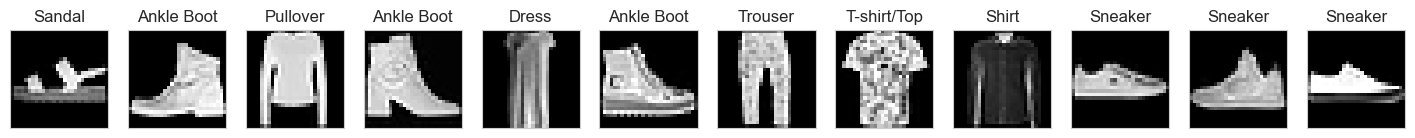

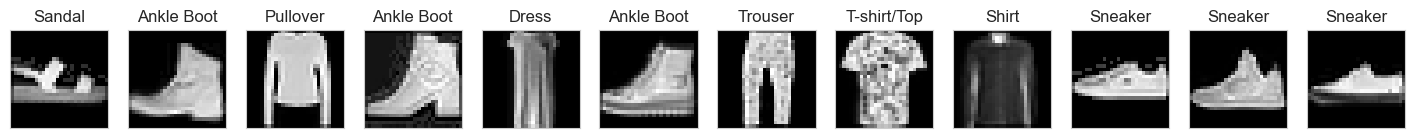

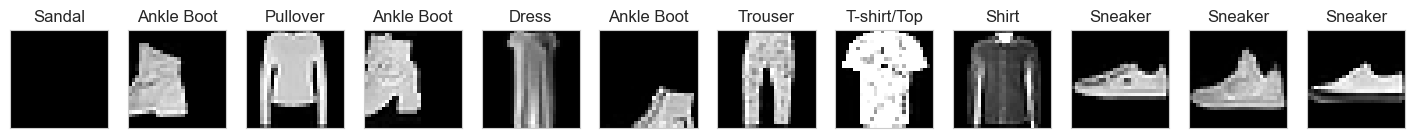

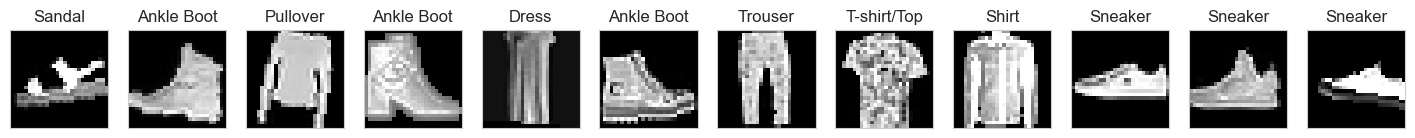

In [93]:
show_from_loader(train_dataset, augmentation=base_augmentation, rows=1, cols=12)
show_from_loader(train_dataset, augmentation=augmentation_v1_simple, rows=1, cols=12)
show_from_loader(train_dataset, augmentation=augmentation_v2_auto, rows=1, cols=12)
show_from_loader(train_dataset, augmentation=augmentation_v3_auto, rows=1, cols=12)
show_from_loader(train_dataset, augmentation=augmentation_v4_auto, rows=1, cols=12)

In [88]:
class Model_CNN_Aug(nn.Module):
    base_name = "Model_CNN_3_Augment"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        
        self.layer1 = nn.Sequential(  # 28x28 -> 13x13
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            # nn.Dropout2d(p=0.08),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(  # 13x13 -> 6x6
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.15),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(  # 6x6 -> 3x3
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.15),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(  # 3x3 -> 3x3
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=2, padding=0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc1 = nn.Linear(384, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc_dropout = nn.Dropout(p=0.1)

    def forward(self, x1):
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        
        f1 = torch.flatten(x5, start_dim=1)
        f2 = self.fc_dropout(F.relu(self.bn1(self.fc1(f1))))
        f3 = self.fc_dropout(F.relu(self.bn2(self.fc2(f2))))
        logits = self.fc3(f3)
        return logits

In [94]:
# Instantiate our model
model_cnn_aug = Model_CNN_Aug()
model_cnn_aug = model_cnn_aug.to(device)

# Summary (1 or 2)
summary(model_cnn_aug, input_size=(1, 28, 28), batch_size=128)
# print(str(info_summary(model_cnn_aug, input_size=(128, 1, 28, 28),
#                        col_names=["mult_adds", "output_size", "num_params"], row_settings=["var_names"])))

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 3e-3
cnn_aug_optimizer = torch.optim.Adam(model_cnn_aug.parameters(), lr=learning_rate)

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_aug_optimizer, 'min', patience=2, factor=0.65, min_lr=5e-5)
early_stopping = EarlyStopping(tolerance=8, min_delta=0.005)
callbacks_model = {"lr_scheduler": lr_scheduler,
                   "early_stopping": early_stopping}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 48, 27, 27]             768
       BatchNorm2d-2          [128, 48, 27, 27]              96
              ReLU-3          [128, 48, 27, 27]               0
            Conv2d-4          [128, 64, 27, 27]          27,648
       BatchNorm2d-5          [128, 64, 27, 27]             128
              ReLU-6          [128, 64, 27, 27]               0
         Dropout2d-7          [128, 64, 27, 27]               0
         MaxPool2d-8          [128, 64, 13, 13]               0
            Conv2d-9          [128, 64, 13, 13]          36,864
      BatchNorm2d-10          [128, 64, 13, 13]             128
             ReLU-11          [128, 64, 13, 13]               0
        Dropout2d-12          [128, 64, 13, 13]               0
        MaxPool2d-13            [128, 64, 6, 6]               0
           Conv2d-14            [128, 9

Epoch: 1/1000 	 Train Loss: 0.561	 Val Loss: 0.336	 Train Accuracy: 0.796	 Val Accuracy: 0.880	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.342	 Val Loss: 0.287	 Train Accuracy: 0.877	 Val Accuracy: 0.894	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.290	 Val Loss: 0.323	 Train Accuracy: 0.896	 Val Accuracy: 0.886	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.259	 Val Loss: 0.241	 Train Accuracy: 0.905	 Val Accuracy: 0.917	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.237	 Val Loss: 0.231	 Train Accuracy: 0.914	 Val Accuracy: 0.922	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.222	 Val Loss: 0.226	 Train Accuracy: 0.919	 Val Accuracy: 0.921	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.205	 Val Loss: 0.211	 Train Accuracy: 0.925	 Val Accuracy: 0.925	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.193	 Val Loss: 0.205	 Train Accuracy: 0.931	 Val Accuracy: 0.926	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.180	 Val Loss: 0.211	 Train Accuracy: 0.935	 Val Accuracy: 0.928	 Lr (e-3): 3.00
E

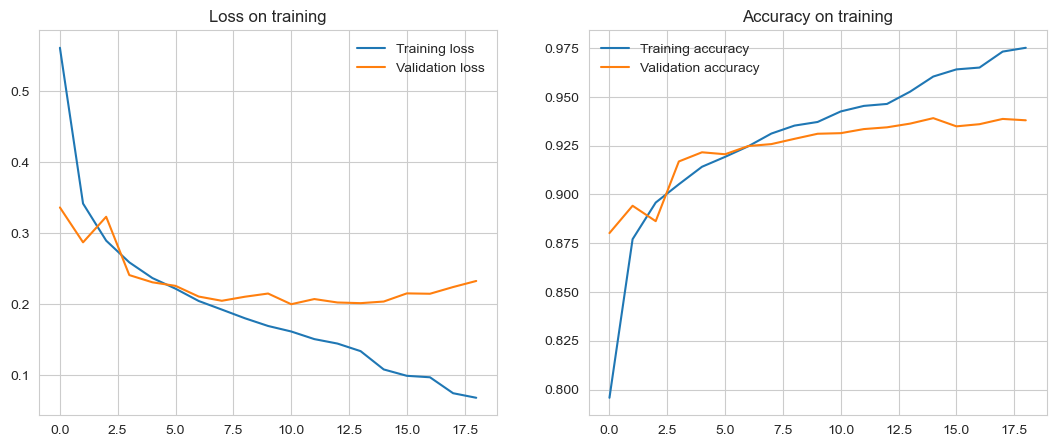

              precision    recall  f1-score   support

 T-shirt/Top       0.90      0.86      0.88       899
     Trouser       0.99      0.99      0.99      1043
    Pullover       0.93      0.90      0.91      1003
       Dress       0.94      0.95      0.95      1021
        Coat       0.88      0.93      0.91      1020
      Sandal       0.99      0.99      0.99      1008
       Shirt       0.82      0.83      0.83      1014
     Sneaker       0.97      0.96      0.96      1014
         Bag       1.00      0.98      0.99       974
  Ankle Boot       0.96      0.98      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9380


In [95]:
history = train(model_cnn_aug, cnn_aug_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=base_augmentation)
test_model(model_cnn_aug, val_loader, history_to_show=history)

Epoch: 1/1000 	 Train Loss: 0.606	 Val Loss: 0.384	 Train Accuracy: 0.783	 Val Accuracy: 0.860	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.379	 Val Loss: 0.324	 Train Accuracy: 0.861	 Val Accuracy: 0.884	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.326	 Val Loss: 0.289	 Train Accuracy: 0.881	 Val Accuracy: 0.899	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.300	 Val Loss: 0.283	 Train Accuracy: 0.891	 Val Accuracy: 0.899	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.275	 Val Loss: 0.278	 Train Accuracy: 0.900	 Val Accuracy: 0.901	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.267	 Val Loss: 0.243	 Train Accuracy: 0.903	 Val Accuracy: 0.917	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.255	 Val Loss: 0.230	 Train Accuracy: 0.907	 Val Accuracy: 0.920	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.243	 Val Loss: 0.226	 Train Accuracy: 0.912	 Val Accuracy: 0.918	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.232	 Val Loss: 0.241	 Train Accuracy: 0.917	 Val Accuracy: 0.921	 Lr (e-3): 3.00
E

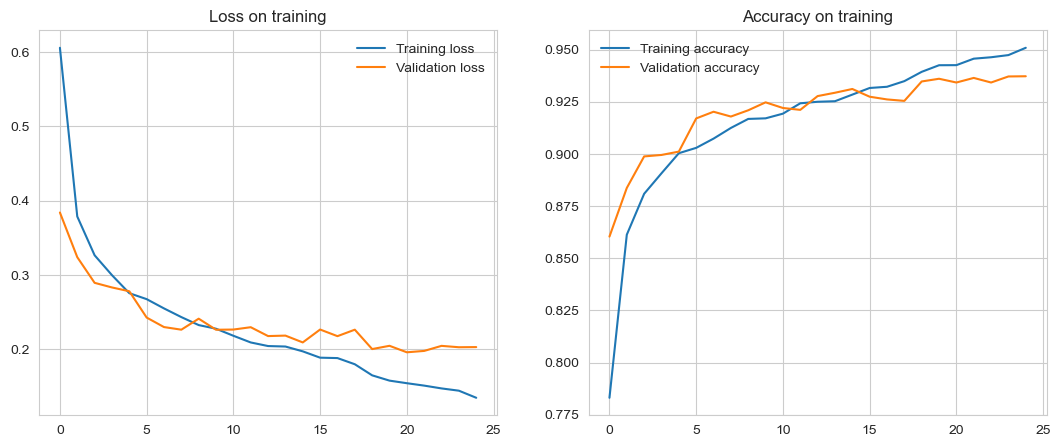

              precision    recall  f1-score   support

 T-shirt/Top       0.91      0.88      0.89       899
     Trouser       0.99      1.00      0.99      1043
    Pullover       0.91      0.90      0.91      1003
       Dress       0.95      0.94      0.95      1021
        Coat       0.89      0.94      0.91      1020
      Sandal       0.99      0.99      0.99      1008
       Shirt       0.85      0.83      0.84      1014
     Sneaker       0.97      0.97      0.97      1014
         Bag       1.00      0.99      1.00       974
  Ankle Boot       0.97      0.98      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9432


In [90]:
history = train(model_cnn_aug, cnn_aug_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v2_auto)
test_model(model_cnn_aug, val_loader, history_to_show=history)

Epoch: 1/1000 	 Train Loss: 0.586	 Val Loss: 0.359	 Train Accuracy: 0.791	 Val Accuracy: 0.870	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.355	 Val Loss: 0.297	 Train Accuracy: 0.874	 Val Accuracy: 0.898	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.309	 Val Loss: 0.260	 Train Accuracy: 0.889	 Val Accuracy: 0.912	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.278	 Val Loss: 0.270	 Train Accuracy: 0.901	 Val Accuracy: 0.908	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.261	 Val Loss: 0.243	 Train Accuracy: 0.906	 Val Accuracy: 0.916	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.244	 Val Loss: 0.246	 Train Accuracy: 0.911	 Val Accuracy: 0.918	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.230	 Val Loss: 0.231	 Train Accuracy: 0.918	 Val Accuracy: 0.921	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.217	 Val Loss: 0.234	 Train Accuracy: 0.921	 Val Accuracy: 0.918	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.210	 Val Loss: 0.231	 Train Accuracy: 0.924	 Val Accuracy: 0.922	 Lr (e-3): 3.00
E

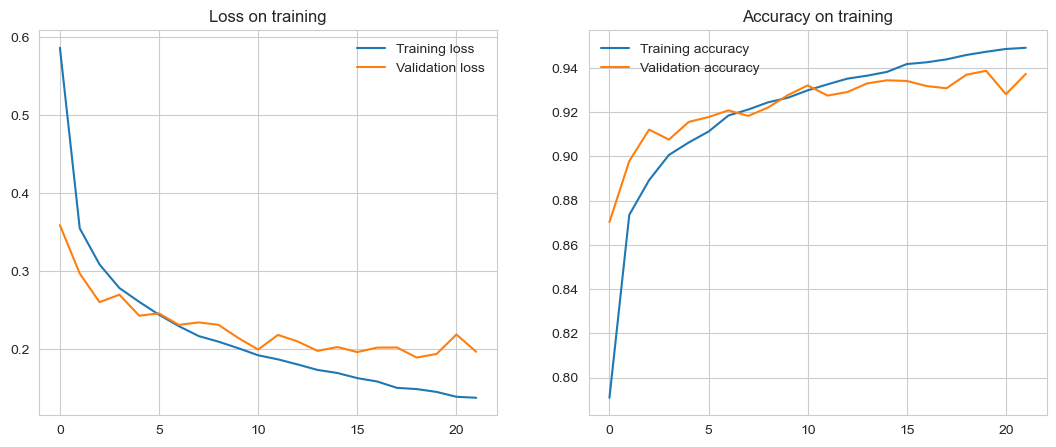

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.88      0.88       899
     Trouser       0.99      1.00      0.99      1043
    Pullover       0.93      0.89      0.91      1003
       Dress       0.94      0.95      0.95      1021
        Coat       0.89      0.93      0.91      1020
      Sandal       0.99      0.98      0.99      1008
       Shirt       0.83      0.81      0.82      1014
     Sneaker       0.98      0.95      0.96      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.95      0.99      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9372


In [92]:
history = train(model_cnn_aug, cnn_aug_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v1_simple)
test_model(model_cnn_aug, val_loader, history_to_show=history)

### Выводы (Задача 3)
Я добавил аугментацию данных. Из-за того что датасет достаточно большой, а объекты простые (28*28 grayscale), аугментация не дала такого скачка в обучении, как могла бы на более бедном датасете с большими картинками (94,3% против 93,8% точности). Но возможно на других архитектурах она даст больший эффект.

## **Stage 4** - Задача 4 - ResNet & SqueezeNet & skip-connection
[https://habr.com/ru/companies/nix/articles/430524/](https://habr.com/ru/companies/nix/articles/430524/)


In [116]:
class DepthSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, **kwargs):
        super(DepthSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x1):
        x2 = self.depthwise(x1)
        x3 = self.pointwise(x2)
        return x3

### Residual Net
[Архитектура](https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/)

In [132]:
class Model_ResNet(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_channels: int, out_channels: int):
            super().__init__()
            self.conv1 = DepthSeparableConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.conv2 = DepthSeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            
            self.dropout2d = nn.Dropout2d(p=0.2)
            self.in_out_eq = in_channels == out_channels
            if not self.in_out_eq:
                self.res_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding=0)

        def forward(self, x1):
            x2 = self.conv1(x1)
            x3 = F.relu(self.dropout2d(self.bn1(x2)))
            x4 = self.conv2(x3)
            x5 = self.dropout2d(self.bn2(x4))
            
            if self.in_out_eq:
                res_x = x1
            else:
                res_x = self.res_conv(x1)
            
            x_out = x5 + res_x
            return F.relu(x_out)


    base_name = "Model_4_ResNet"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        
        self.first_layer = nn.Sequential(  # 28x28 -> 28x28
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),)
        
        self.block1 = Model_ResNet.Block(64, 64)
        self.block3 = Model_ResNet.Block(64, 128)
        self.block4 = Model_ResNet.Block(128, 128)
        self.block5 = Model_ResNet.Block(128, 256)
        self.block6 = Model_ResNet.Block(256, 256)
        self.block7 = Model_ResNet.Block(256, 512)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.max_pool_x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.first_layer(x)
        
        x = self.block1(x)
        x = self.max_pool_x2(x)  # 28 -> 14
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.max_pool_x2(x)  # 14 -> 7
        
        x = self.block5(x)
        x = self.block6(x)
        x = self.max_pool_x2(x)  # 7 -> 3
        
        x = self.block7(x)
        
        x = self.avg_pool(x)
        f1 = torch.flatten(x, start_dim=1)
        f2 = self.fc_dropout(F.relu(self.bn1(self.fc1(f1))))
        f3 = self.fc_dropout(F.relu(self.bn2(self.fc2(f2))))
        logits = self.fc3(f3)
        return logits

In [261]:
# Instantiate our model
model_res_net = Model_ResNet()
model_res_net = model_res_net.to(device)

# Summary (1 or 2)
# summary(model_res_net, input_size=(1, 28, 28), batch_size=128)
print(str(info_summary(model_res_net, input_size=(128, 1, 28, 28),
                       col_names=["mult_adds", "output_size", "num_params"], row_settings=["var_names"])))

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 3e-3
res_net_optimizer = torch.optim.Adam(model_res_net.parameters(), lr=learning_rate)

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(res_net_optimizer, 'min', patience=1, factor=0.7, min_lr=5e-5)
early_stopping = EarlyStopping(tolerance=9, min_delta=0.004)
callbacks_model = {"lr_scheduler": lr_scheduler,
                   "early_stopping": early_stopping}

# With Separable: 780_000 params vs 7_500_000 without

Layer (type (var_name))                  Mult-Adds                 Output Shape              Param #
Model_ResNet (Model_ResNet)              --                        [128, 10]                 --
├─Sequential (first_layer)               --                        [128, 64, 28, 28]         --
│    └─Conv2d (0)                        160,563,200               [128, 64, 28, 28]         1,600
│    └─BatchNorm2d (1)                   16,384                    [128, 64, 28, 28]         128
│    └─ReLU (2)                          --                        [128, 64, 28, 28]         --
├─Block (block1)                         --                        [128, 64, 28, 28]         --
│    └─DepthSeparableConv2d (conv1)      --                        [128, 64, 28, 28]         --
│    │    └─Conv2d (depthwise)           64,225,280                [128, 64, 28, 28]         640
│    │    └─Conv2d (pointwise)           417,464,320               [128, 64, 28, 28]         4,160
│    └─BatchNorm2d (bn1)   

In [241]:
save_model(model_res_net)

Epoch: 1/1000 	 Train Loss: 0.677	 Val Loss: 0.486	 Train Accuracy: 0.757	 Val Accuracy: 0.833	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.387	 Val Loss: 0.322	 Train Accuracy: 0.862	 Val Accuracy: 0.887	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.339	 Val Loss: 0.298	 Train Accuracy: 0.879	 Val Accuracy: 0.896	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.307	 Val Loss: 0.283	 Train Accuracy: 0.892	 Val Accuracy: 0.900	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.289	 Val Loss: 0.287	 Train Accuracy: 0.895	 Val Accuracy: 0.903	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.278	 Val Loss: 0.251	 Train Accuracy: 0.900	 Val Accuracy: 0.908	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.262	 Val Loss: 0.256	 Train Accuracy: 0.907	 Val Accuracy: 0.912	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.253	 Val Loss: 0.250	 Train Accuracy: 0.909	 Val Accuracy: 0.915	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.248	 Val Loss: 0.249	 Train Accuracy: 0.911	 Val Accuracy: 0.917	 Lr (e-3): 3.00
E

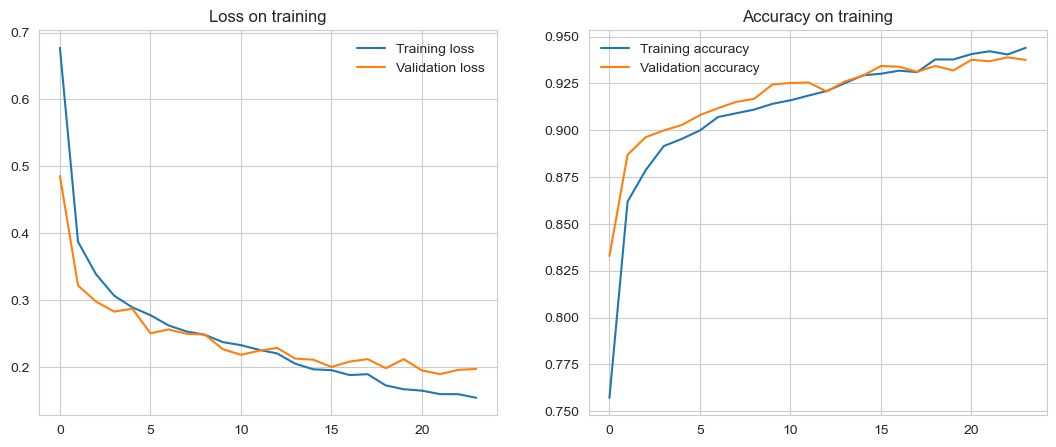

              precision    recall  f1-score   support

 T-shirt/Top       0.89      0.90      0.90       899
     Trouser       0.99      1.00      0.99      1043
    Pullover       0.92      0.92      0.92      1003
       Dress       0.96      0.96      0.96      1021
        Coat       0.90      0.92      0.91      1020
      Sandal       0.99      0.99      0.99      1008
       Shirt       0.87      0.83      0.85      1014
     Sneaker       0.97      0.98      0.98      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.98      0.97      0.97      1004

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.94      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000
 samples avg       0.95      0.95      0.95     10000

Accuracy test:  0.9456


In [262]:
history = train(model_res_net, res_net_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v2_auto)
test_model(model_res_net, val_loader, history_to_show=history)

Epoch: 1/1000 	 Train Loss: 0.679	 Val Loss: 0.447	 Train Accuracy: 0.752	 Val Accuracy: 0.845	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.392	 Val Loss: 0.307	 Train Accuracy: 0.860	 Val Accuracy: 0.892	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.340	 Val Loss: 0.291	 Train Accuracy: 0.877	 Val Accuracy: 0.895	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.310	 Val Loss: 0.282	 Train Accuracy: 0.889	 Val Accuracy: 0.901	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.293	 Val Loss: 0.309	 Train Accuracy: 0.896	 Val Accuracy: 0.894	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.279	 Val Loss: 0.250	 Train Accuracy: 0.899	 Val Accuracy: 0.910	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.263	 Val Loss: 0.253	 Train Accuracy: 0.906	 Val Accuracy: 0.910	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.257	 Val Loss: 0.242	 Train Accuracy: 0.908	 Val Accuracy: 0.920	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.255	 Val Loss: 0.230	 Train Accuracy: 0.910	 Val Accuracy: 0.924	 Lr (e-3): 3.00
E

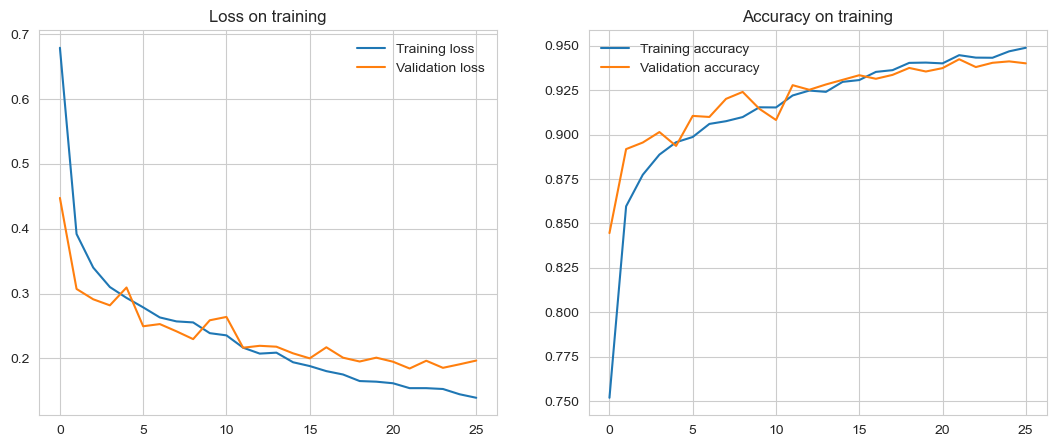

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.91      0.90       899
     Trouser       0.99      1.00      0.99      1043
    Pullover       0.92      0.92      0.92      1003
       Dress       0.95      0.95      0.95      1021
        Coat       0.91      0.92      0.92      1020
      Sandal       0.99      0.98      0.99      1008
       Shirt       0.86      0.81      0.83      1014
     Sneaker       0.97      0.98      0.97      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.98      0.98      0.98      1004

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.94      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000
 samples avg       0.95      0.95      0.95     10000

Accuracy test:  0.9454


In [137]:
history = train(model_res_net, res_net_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v2_auto)
test_model(model_res_net, val_loader, history_to_show=history)

### Squezze Net
[Архитектура 1](https://towardsdatascience.com/review-squeezenet-image-classification-e7414825581a)
[Архитектура 2](https://medium.com/sfu-cspmp/squeezenet-the-key-to-unlocking-the-potential-of-edge-computing-c8b224d839ba)
[Архитектура 3](https://arxiv.org/pdf/1803.10615.pdf)
[YouTube видео](https://www.youtube.com/watch?v=_jTZpSh5ZR4&ab_channel=%D0%9C%D0%BE%D1%82%D1%8C%D0%BA%D0%B8%D0%BD%D0%98%D0%98)

In [235]:
class Model_SqueezeNet(nn.Module):
    class FireBlock_1(nn.Module):
        def __init__(self, in_channels: int, out_channels: int):
            super().__init__()
            self.conv_bottleneck = nn.Conv2d(in_channels=in_channels, out_channels=in_channels // 8, kernel_size=1, padding=0)
            self.bn_bottleneck = nn.BatchNorm2d(in_channels // 8)
            
            self.conv_1x1 = nn.Conv2d(in_channels=in_channels // 8, out_channels=out_channels // 2, kernel_size=1, padding=0)
            # self.conv_3x3 = nn.Conv2d(in_channels=in_channels // 8, out_channels=out_channels // 2, kernel_size=3, padding=1)
            self.conv_3x3 = DepthSeparableConv2d(in_channels=in_channels // 8, out_channels=out_channels // 2, kernel_size=3)
            # self.conv_3x3 = nn.Sequential(
            #     nn.Conv2d(in_channels=in_channels // 8, out_channels=in_channels // 8, kernel_size=(3, 1), padding=(1, 0)),
            #     # nn.ReLU(), nn.BatchNorm2d(in_channels // 8),
            #     nn.Conv2d(in_channels=in_channels // 8, out_channels=out_channels // 2, kernel_size=(1, 3), padding=(0, 1)),)

            self.dropout = nn.Dropout2d(p=0.15)
            self.bn_out = nn.BatchNorm2d(out_channels)

        def forward(self, x_in):
            x_bottle = F.relu(self.conv_bottleneck(x_in))
            x_bottle = self.bn_bottleneck(x_bottle)
            
            x_1x1 = self.conv_1x1(x_bottle)
            x_3x3 = self.conv_3x3(x_bottle)

            x_out = torch.cat([x_1x1, x_3x3], dim=1)
            x_out = F.relu(self.bn_out(x_out))
            return x_out

    base_name = "Model_4_SqueezeNet"
    def __init__(self, name=base_name):
        super().__init__()
        self.name = name
        
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(64), nn.ReLU())
        
        self.block1 = Model_SqueezeNet.FireBlock_1(64, 128)
        self.block2 = Model_SqueezeNet.FireBlock_1(128, 128)
        self.block3 = Model_SqueezeNet.FireBlock_1(128, 128)
        self.block4 = Model_SqueezeNet.FireBlock_1(128, 128)
        self.block5 = Model_SqueezeNet.FireBlock_1(128, 256)
        self.block6 = Model_SqueezeNet.FireBlock_1(256, 256)
        self.block7 = Model_SqueezeNet.FireBlock_1(256, 256)
        self.block8 = Model_SqueezeNet.FireBlock_1(256, 256)
        self.block9 = Model_SqueezeNet.FireBlock_1(256, 512)
        
        self.end_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.5))
        
        self.last_conv = nn.Conv2d(512, 10, kernel_size=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.max_pool_x2_3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_02 = nn.Dropout(p=0.2)
        self.dropout_05 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.block1(x)
        x = self.max_pool_x2_3(x)  # 28 -> 14
        
        x = self.block2(x) + x  # Res
        x = self.block3(x) + x  # Res
        x = self.block4(x) + x  # Res
        x = self.block5(x)
        x = self.max_pool_x2_3(x)  # 14 -> 7
        
        x = self.block6(x) + x  # Res
        x = self.block7(x) + x  # Res
        x = self.block8(x) + x  # Res
        x = self.max_pool_x2_3(x)  # 7 -> 3
        
        x = self.block9(x)
        
        x = self.end_conv(x)
        # x = self.last_conv(x)
        x = self.avg_pool(x)
        
        x = self.dropout_05(x)
        fc = torch.flatten(x, start_dim=1)
        fc = self.dropout_02(F.relu(self.bn1(self.fc1(fc))))
        logits = self.fc2(fc)
        # logits = torch.flatten(x, start_dim=1)
        return logits

In [258]:
# Instantiate our model
model_squeeze = Model_SqueezeNet()
model_squeeze = model_squeeze.to(device)

# Summary (1 or 2)
# summary(model_squeeze, input_size=(1, 28, 28), batch_size=128)
print(str(info_summary(model_squeeze, input_size=(128, 1, 28, 28),
                       col_names=["mult_adds", "output_size", "num_params"], row_settings=["var_names"])))

# Define our loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
learning_rate = 3e-3
squeeze_optimizer = torch.optim.Adam(model_squeeze.parameters(), lr=learning_rate)

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(squeeze_optimizer, 'min', patience=1, factor=0.7, min_lr=5e-5)
early_stopping = EarlyStopping(tolerance=10, min_delta=0.003)
callbacks_model = {"lr_scheduler": lr_scheduler,
                   "early_stopping": early_stopping}

Layer (type (var_name))                       Mult-Adds                 Output Shape              Param #
Model_SqueezeNet (Model_SqueezeNet)           --                        [128, 10]                 5,130
├─Sequential (first_layer)                    --                        [128, 64, 28, 28]         --
│    └─Conv2d (0)                             160,563,200               [128, 64, 28, 28]         1,600
│    └─BatchNorm2d (1)                        16,384                    [128, 64, 28, 28]         128
│    └─ReLU (2)                               --                        [128, 64, 28, 28]         --
├─FireBlock_1 (block1)                        --                        [128, 128, 28, 28]        --
│    └─Conv2d (conv_bottleneck)               52,183,040                [128, 8, 28, 28]          520
│    └─BatchNorm2d (bn_bottleneck)            2,048                     [128, 8, 28, 28]          16
│    └─Conv2d (conv_1x1)                      57,802,752                [128, 

In [260]:
save_model(model_squeeze)

Epoch: 1/1000 	 Train Loss: 0.761	 Val Loss: 0.564	 Train Accuracy: 0.717	 Val Accuracy: 0.792	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.462	 Val Loss: 0.374	 Train Accuracy: 0.833	 Val Accuracy: 0.865	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.392	 Val Loss: 0.318	 Train Accuracy: 0.859	 Val Accuracy: 0.888	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.360	 Val Loss: 0.305	 Train Accuracy: 0.872	 Val Accuracy: 0.890	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.332	 Val Loss: 0.290	 Train Accuracy: 0.881	 Val Accuracy: 0.899	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.319	 Val Loss: 0.266	 Train Accuracy: 0.887	 Val Accuracy: 0.903	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.305	 Val Loss: 0.264	 Train Accuracy: 0.891	 Val Accuracy: 0.904	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.294	 Val Loss: 0.248	 Train Accuracy: 0.895	 Val Accuracy: 0.909	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.286	 Val Loss: 0.251	 Train Accuracy: 0.900	 Val Accuracy: 0.915	 Lr (e-3): 3.00
E

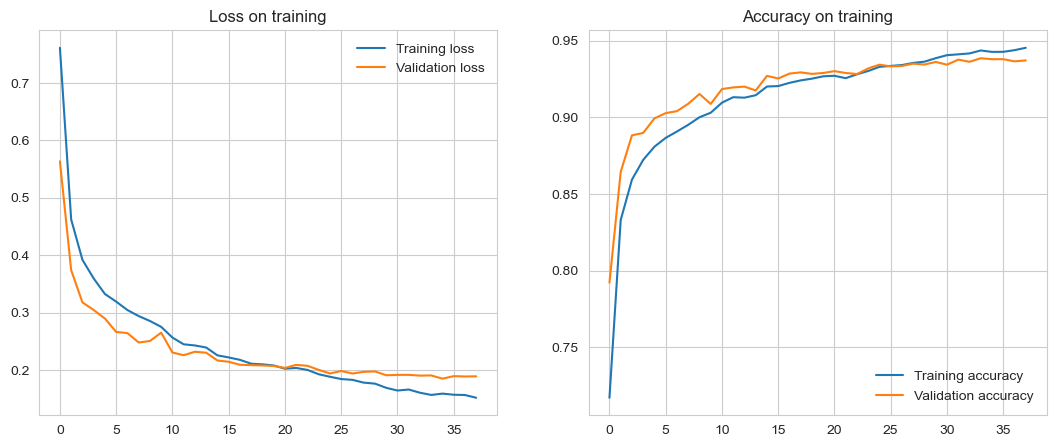

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.89      0.88       899
     Trouser       1.00      0.99      0.99      1043
    Pullover       0.92      0.91      0.92      1003
       Dress       0.94      0.96      0.95      1021
        Coat       0.90      0.92      0.91      1020
      Sandal       0.99      0.98      0.98      1008
       Shirt       0.85      0.81      0.83      1014
     Sneaker       0.96      0.97      0.97      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.97      0.98      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9400


In [259]:
history = train(model_squeeze, squeeze_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v1_simple)
test_model(model_squeeze, val_loader, history_to_show=history)

Epoch: 1/1000 	 Train Loss: 0.847	 Val Loss: 0.509	 Train Accuracy: 0.674	 Val Accuracy: 0.801	 Lr (e-3): 3.00
Epoch: 2/1000 	 Train Loss: 0.504	 Val Loss: 0.370	 Train Accuracy: 0.818	 Val Accuracy: 0.870	 Lr (e-3): 3.00
Epoch: 3/1000 	 Train Loss: 0.423	 Val Loss: 0.353	 Train Accuracy: 0.850	 Val Accuracy: 0.874	 Lr (e-3): 3.00
Epoch: 4/1000 	 Train Loss: 0.380	 Val Loss: 0.336	 Train Accuracy: 0.865	 Val Accuracy: 0.882	 Lr (e-3): 3.00
Epoch: 5/1000 	 Train Loss: 0.363	 Val Loss: 0.310	 Train Accuracy: 0.871	 Val Accuracy: 0.886	 Lr (e-3): 3.00
Epoch: 6/1000 	 Train Loss: 0.340	 Val Loss: 0.289	 Train Accuracy: 0.878	 Val Accuracy: 0.893	 Lr (e-3): 3.00
Epoch: 7/1000 	 Train Loss: 0.328	 Val Loss: 0.274	 Train Accuracy: 0.883	 Val Accuracy: 0.903	 Lr (e-3): 3.00
Epoch: 8/1000 	 Train Loss: 0.315	 Val Loss: 0.267	 Train Accuracy: 0.887	 Val Accuracy: 0.907	 Lr (e-3): 3.00
Epoch: 9/1000 	 Train Loss: 0.304	 Val Loss: 0.252	 Train Accuracy: 0.892	 Val Accuracy: 0.910	 Lr (e-3): 3.00
E

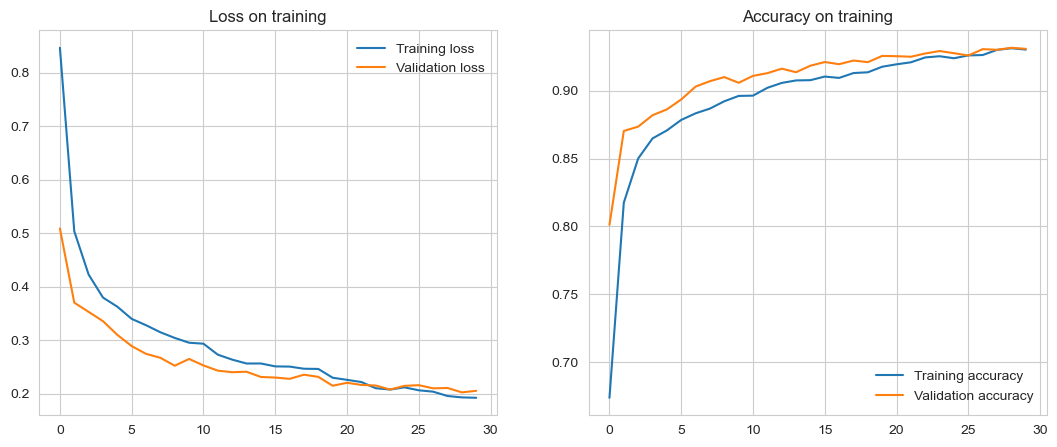

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.89      0.89       899
     Trouser       1.00      0.99      0.99      1043
    Pullover       0.90      0.90      0.90      1003
       Dress       0.94      0.97      0.95      1021
        Coat       0.90      0.90      0.90      1020
      Sandal       0.99      0.99      0.99      1008
       Shirt       0.83      0.81      0.82      1014
     Sneaker       0.97      0.97      0.97      1014
         Bag       0.99      0.99      0.99       974
  Ankle Boot       0.97      0.98      0.97      1004

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9385


In [239]:
history = train(model_squeeze, squeeze_optimizer, loss_fn=loss_function, callbacks=callbacks_model, augmentation=augmentation_v2_auto)
test_model(model_squeeze, val_loader, history_to_show=history)

### Выводы (Задача 3)
Я добавил skip-connection архитектуры ResNet и SqueezeNet. Протестировал их, однако результат не сильно превысил изначальную свёрточную сеть (при том что сеть стала больше и тяжелее).

## Итоги работы

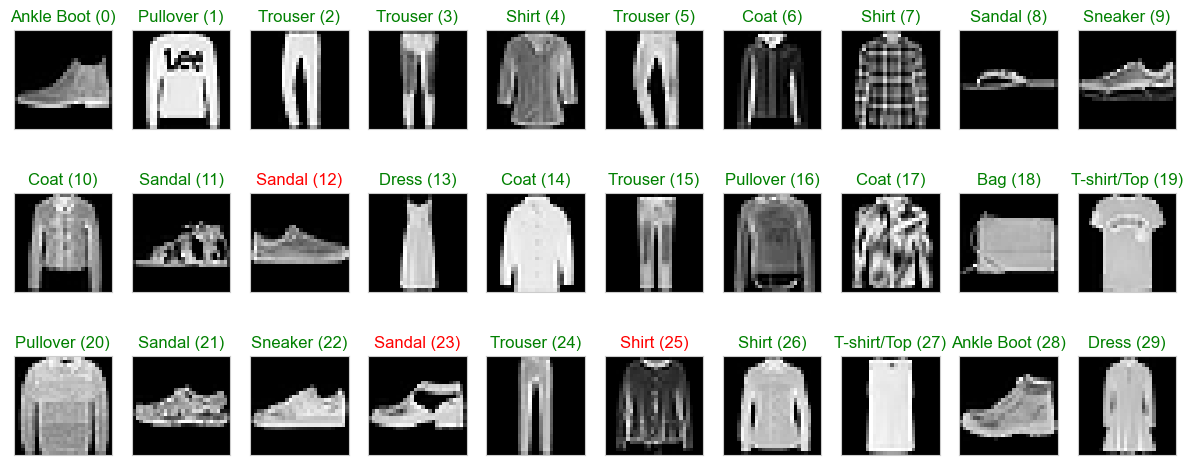

['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] (1, 10)


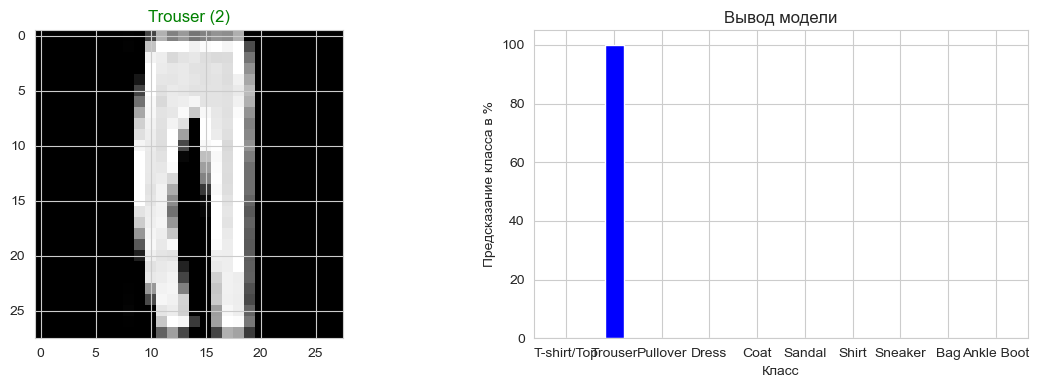

['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
[[0.   0.   0.   0.   0.   0.63 0.   0.33 0.   0.04]] (1, 10)


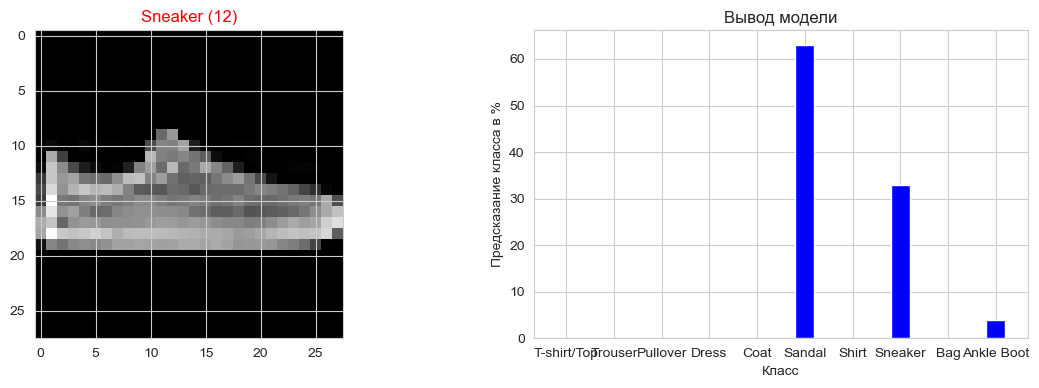

['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
[[0.   0.   0.26 0.   0.16 0.   0.58 0.   0.   0.  ]] (1, 10)


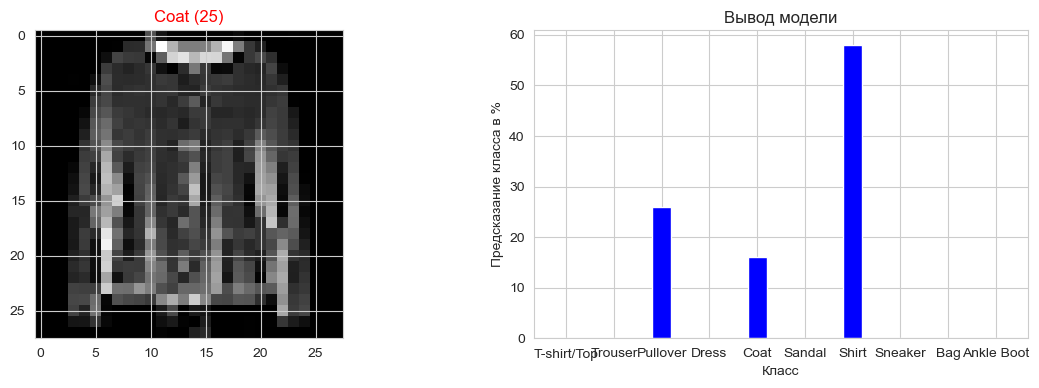

In [234]:
def show_model_test(dataset: TensorDataset, model: nn.Module, augmentation=base_augmentation, rows=2, cols=10, start_idx=0):
    imgs_, labels_ = dataset[start_idx:start_idx+rows * cols]
    model_out = get_softmax(model, imgs_, augmentation=augmentation)
    
    pred = np.argmax(model_out, axis=1, keepdims=True)
    y_true = np.argmax(labels_.numpy(), axis=1, keepdims=True)
    
    plt.figure(figsize=(int(1.55*cols), 2*rows))
    for i in range(cols*rows):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.expand_dims(np.squeeze(augmentation(imgs_[i])), axis=-1), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{labels_map[pred[i, 0]]} ({start_idx + i})", c='g' if y_true[i, 0] == pred[i, 0] else 'r')
    
    plt.show()
    

def show_one_test(dataset: TensorDataset, model: nn.Module, idx: int, augmentation=base_augmentation):
    img_, label_ = dataset[idx]

    model_out = get_softmax(model, img_[None, :, :, :], augmentation=augmentation, round_res=2)
    pred, y_true = np.argmax(model_out), np.argmax(label_.numpy())
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.expand_dims(np.squeeze(augmentation(img_)), axis=-1), cmap='gray')
    plt.title(f"{labels_map[y_true]} ({idx})", c='g' if y_true == pred else 'r')
    
    class_names = list(labels_map.values())
    print([f"{class_names[i]}" for i in range(10)])
    print(model_out, model_out.shape)
    plt.subplot(1, 2, 2)
    plt.bar([class_names[i] for i in range(10)], np.squeeze(model_out) * 100, color='b', width=0.4)
    plt.xlabel("Класс")
    plt.ylabel("Предсказание класса в %")
    plt.title("Вывод модели")
    plt.show()
    

show_model_test(test_dataset, model_squeeze, rows=3, cols=10)
show_one_test(test_dataset, model_squeeze, idx=2)
show_one_test(test_dataset, model_squeeze, idx=12)
show_one_test(test_dataset, model_squeeze, idx=25)

### Testing models

In [245]:
model = load_model(Model_FNN_Small)
test_model(model, test_loader, augmentation=base_augmentation)

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.76      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.77      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.79      0.84      0.82      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.66      0.74      0.70      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.96      0.97      0.96      1000
  Ankle Boot       0.95      0.96      0.95      1000

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000
 samples avg       0.88      0.88      0.88     10000

Accuracy test:  0.8795


In [246]:
model = load_model(Model_FNN_Large)
test_model(model, test_loader, augmentation=base_augmentation)

              precision    recall  f1-score   support

 T-shirt/Top       0.84      0.83      0.83      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.79      0.84      0.81      1000
       Dress       0.88      0.91      0.89      1000
        Coat       0.84      0.82      0.83      1000
      Sandal       0.98      0.95      0.96      1000
       Shirt       0.73      0.67      0.70      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.96      0.97      0.97      1000
  Ankle Boot       0.95      0.96      0.95      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000
 samples avg       0.89      0.89      0.89     10000

Accuracy test:  0.8892


In [255]:
model = load_model(Model_CNN)
test_model(model, test_loader, augmentation=base_augmentation)

              precision    recall  f1-score   support

 T-shirt/Top       0.87      0.90      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.92      0.89      0.90      1000
       Dress       0.93      0.94      0.94      1000
        Coat       0.87      0.93      0.90      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.83      0.77      0.80      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.98      0.96      0.97      1000

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000
 samples avg       0.93      0.93      0.93     10000

Accuracy test:  0.9328


In [263]:
model = load_model(Model_SqueezeNet)
test_model(model, test_loader, augmentation=base_augmentation)

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.89      0.88      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.90      0.91      1000
       Dress       0.93      0.95      0.94      1000
        Coat       0.89      0.92      0.90      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.81      0.78      0.79      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.97      0.97      0.97      1000

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000
 samples avg       0.93      0.93      0.93     10000

Accuracy test:  0.9337


In [253]:
model = load_model(Model_ResNet)
test_model(model, test_loader, augmentation=base_augmentation)

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.91      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.95      0.94      0.94      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.82      0.79      0.80      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.98      0.96      0.97      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
 samples avg       0.94      0.94      0.94     10000

Accuracy test:  0.9380


По итогу получилось достигнуть точности в 94.5 % на тестовой части (простая ResNet с аугментацией). В работе я поке не применял ignite (но в дальнейшем для простоты буду). Похоже ResNet и SqueezeNet оказались слишком большими для тонкой настройки и для этого датасета, из-за чего они либо могли выучить трейновый датасет, либо дропаут был таким большим, что от большого размера сети не было смысла. Аугментации дали прирост, но совсем не большой для этого датасета. 